In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 2s (78.7 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("TaxiDataAnalysis").getOrCreate()

# URL of the dataset
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Add file to Spark's distributed file system
spark.sparkContext.addFile(url)

# Read the file using the exact name from the URL
df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True)

# Show the data
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [5]:
# Display the schema
df.printSchema()

# Summary statistics
df.describe().show()

# Check for missing values
df.select([df[col].isNull().alias(col) for col in df.columns]).show()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)

+-------+---------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-----------------+
|summary|       id|          vendor_id|    pickup_datetime|   dropoff_datetime|   passenger_count|   pickup_longitude|    pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|    trip_duration|
+-------+---------+-------------------+-------------------

In [6]:
# Example of defining df_cleaned
df_cleaned = df.dropna()  # Cleaning step example

In [7]:
%whos

Variable        Type            Data/Info
-----------------------------------------
SparkFiles      type            <class 'pyspark.files.SparkFiles'>
SparkSession    type            <class 'pyspark.sql.session.SparkSession'>
df              DataFrame       DataFrame[id: string, ven<...>g, trip_duration: string]
df_cleaned      DataFrame       DataFrame[id: string, ven<...>g, trip_duration: string]
findspark       module          <module 'findspark' from <...>t-packages/findspark.py'>
os              module          <module 'os' from '/usr/lib/python3.10/os.py'>
sns             module          <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
spark           SparkSession    <pyspark.sql.session.Spar<...>object at 0x7d8c5ef8b310>
spark_version   str             spark-3.4.4
time            module          <module 'time' (built-in)>
url             str             https://project4-nyctaxi.<...>1.amazonaws.com/train.csv


In [8]:
# Example: Assuming the raw DataFrame is `df`
df_cleaned = df.dropna()  # Dropping rows with missing values
df_cleaned = df_cleaned.filter("trip_duration > 0")  # Example filter

In [9]:
print(df.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [10]:
print(df_cleaned.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [11]:
from pyspark.ml.feature import StringIndexer

In [12]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")

In [13]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df_encoded = indexer.fit(df_cleaned).transform(df_cleaned)
df_encoded.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|store_and_fwd_index|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|                0.0|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|         

In [14]:
df_cleaned.select("store_and_fwd_flag").distinct().show()

+------------------+
|store_and_fwd_flag|
+------------------+
|                 Y|
|                 N|
+------------------+



In [15]:
print(df_cleaned.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [16]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df_encoded = indexer.fit(df_cleaned).transform(df_cleaned)
df_encoded.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|store_and_fwd_index|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|                0.0|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|         

In [17]:
df_cleaned.select("store_and_fwd_flag").distinct().show()

+------------------+
|store_and_fwd_flag|
+------------------+
|                 Y|
|                 N|
+------------------+



In [18]:
df_cleaned = df_cleaned.fillna({"store_and_fwd_flag": "N"})

In [19]:
print(df_cleaned.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [20]:
from pyspark.sql.functions import concat_ws

df_cleaned = df_cleaned.withColumn(
    "pickup_location", concat_ws(",", df_cleaned.pickup_latitude, df_cleaned.pickup_longitude)
).withColumn(
    "dropoff_location", concat_ws(",", df_cleaned.dropoff_latitude, df_cleaned.dropoff_longitude)
)

In [21]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df_encoded = indexer.fit(df_cleaned).transform(df_cleaned)

# Verify the new column
print(df_encoded.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_location', 'dropoff_location', 'store_and_fwd_index']


In [23]:
feature_columns = [
    "passenger_count",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "store_and_fwd_index",  # Encoded column
]

In [24]:
print(df_encoded.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_location', 'dropoff_location', 'store_and_fwd_index']


In [25]:
feature_columns = [
    "passenger_count",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "store_and_fwd_index",  # Encoded column
]

In [26]:
from pyspark.sql.functions import col

In [27]:
from pyspark.sql.functions import col

# Cast columns to double
df_encoded = df_encoded.withColumn("passenger_count", col("passenger_count").cast("double"))
df_encoded = df_encoded.withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
df_encoded = df_encoded.withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))

In [28]:
df_encoded.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- trip_duration: string (nullable = true)
 |-- pickup_location: string (nullable = false)
 |-- dropoff_location: string (nullable = false)
 |-- store_and_fwd_index: double (nullable = false)



In [29]:
from pyspark.ml.feature import VectorAssembler

In [30]:
from pyspark.ml.feature import VectorAssembler

# Define the feature columns you want to assemble
feature_columns = ["passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data to include the features column
df_prepared = assembler.transform(df_encoded)

# Display the features and trip_duration
df_prepared.select("features", "trip_duration").show(truncate=False)

+--------------------------------------------------------------------------------+-------------+
|features                                                                        |trip_duration|
+--------------------------------------------------------------------------------+-------------+
|[1.0,40.76793670654297,-73.9821548461914,40.765602111816406,-73.96463012695312] |455          |
|[1.0,40.738563537597656,-73.98041534423828,40.73115158081055,-73.99948120117188]|663          |
|[1.0,40.763938903808594,-73.9790267944336,40.710086822509766,-74.00533294677734]|2124         |
|[1.0,40.719970703125,-74.01004028320312,40.70671844482422,-74.01226806640625]   |429          |
|[1.0,40.793209075927734,-73.97305297851562,40.78252029418945,-73.9729232788086] |435          |
|[6.0,40.74219512939453,-73.98285675048828,40.749183654785156,-73.99208068847656]|443          |
|[4.0,40.75783920288086,-73.9690170288086,40.76589584350586,-73.95740509033203]  |341          |
|[1.0,40.79777908325195,-73.96

In [31]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Cast string columns to numeric types
df_encoded = df_encoded.withColumn("passenger_count", col("passenger_count").cast("double"))
df_encoded = df_encoded.withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
df_encoded = df_encoded.withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))

# Verify schema
df_encoded.printSchema()

# Prepare features
feature_columns = [
    "passenger_count",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "store_and_fwd_index",
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_encoded)

# Display a sample
df_prepared.select("features", "trip_duration").show(truncate=False)

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- trip_duration: string (nullable = true)
 |-- pickup_location: string (nullable = false)
 |-- dropoff_location: string (nullable = false)
 |-- store_and_fwd_index: double (nullable = false)

+------------------------------------------------------------------------------------+-------------+
|features                                                                            |trip_duration|
+------------------------------------------------------------------------------------+-------------+
|[1.0,40.76793670654297,-73.982154846

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [33]:
# Define KMeans model with 3 clusters
kmeans = KMeans(featuresCol="features", k=3)

# Fit the model
kmeans_model = kmeans.fit(df_prepared)

# Make predictions (assign cluster labels to each data point)
predictions = kmeans_model.transform(df_prepared)

# Show the first few predictions with cluster labels
predictions.select("features", "prediction").show(5, truncate=False)

+------------------------------------------------------------------------------------+----------+
|features                                                                            |prediction|
+------------------------------------------------------------------------------------+----------+
|[1.0,40.76793670654297,-73.9821548461914,40.765602111816406,-73.96463012695312,0.0] |1         |
|[1.0,40.738563537597656,-73.98041534423828,40.73115158081055,-73.99948120117188,0.0]|1         |
|[1.0,40.763938903808594,-73.9790267944336,40.710086822509766,-74.00533294677734,0.0]|1         |
|[1.0,40.719970703125,-74.01004028320312,40.70671844482422,-74.01226806640625,0.0]   |1         |
|[1.0,40.793209075927734,-73.97305297851562,40.78252029418945,-73.9729232788086,0.0] |1         |
+------------------------------------------------------------------------------------+----------+
only showing top 5 rows



In [34]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Calculate the Silhouette score
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared Euclidean distance = {silhouette}")

Silhouette with squared Euclidean distance = 0.927523380255995


In [35]:
# Get the cluster centers
centers = kmeans_model.clusterCenters()

# Print the centers
for center in centers:
    print(center)

[ 5.12879933e+00  4.07507831e+01 -7.39729358e+01  4.07516866e+01
 -7.39734229e+01  1.20777627e-03]
[ 9.99941950e-01  4.07512077e+01 -7.39735501e+01  4.07519764e+01
 -7.39733704e+01  6.22484520e-03]
[ 2.22166135e+00  4.07499028e+01 -7.39735578e+01  4.07511877e+01
 -7.39735863e+01  5.26989719e-03]


In [36]:
from pyspark.ml.feature import PCA

# Apply PCA to reduce the dimensionality of the features
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Show the reduced features
pca_result.select("pca_features", "prediction").show(5, truncate=False)

+-----------------------------------------+----------+
|pca_features                             |prediction|
+-----------------------------------------+----------+
|[-0.9843689814076929,-100.81289999963914]|1         |
|[-0.9843761929732877,-100.83907388771489]|1         |
|[-0.9843747970823928,-100.84254600560243]|1         |
|[-0.9843771841013272,-100.87096114577108]|1         |
|[-0.9843656799318012,-100.81055943602553]|1         |
+-----------------------------------------+----------+
only showing top 5 rows



In [37]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Cast string columns to numeric types (if not done earlier)
df_encoded = df_encoded.withColumn("passenger_count", col("passenger_count").cast("double"))
df_encoded = df_encoded.withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
df_encoded = df_encoded.withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
df_encoded = df_encoded.withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))

# Prepare features
feature_columns = [
    "passenger_count",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "store_and_fwd_index",
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_encoded)

# KMeans Clustering
kmeans = KMeans(featuresCol="features", k=3)  # You can change k to the desired number of clusters
kmeans_model = kmeans.fit(df_prepared)

# Make predictions (assign clusters)
predictions = kmeans_model.transform(df_prepared)

# Show some predictions
predictions.select("features", "prediction").show(5, truncate=False)

# Evaluate clustering (Silhouette Score)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared Euclidean distance = {silhouette}")

# Get the cluster centers
centers = kmeans_model.clusterCenters()
for center in centers:
    print(center)

# Optionally, apply PCA for dimensionality reduction and visualization
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Show PCA results
pca_result.select("pca_features", "prediction").show(5, truncate=False)

+------------------------------------------------------------------------------------+----------+
|features                                                                            |prediction|
+------------------------------------------------------------------------------------+----------+
|[1.0,40.76793670654297,-73.9821548461914,40.765602111816406,-73.96463012695312,0.0] |1         |
|[1.0,40.738563537597656,-73.98041534423828,40.73115158081055,-73.99948120117188,0.0]|1         |
|[1.0,40.763938903808594,-73.9790267944336,40.710086822509766,-74.00533294677734,0.0]|1         |
|[1.0,40.719970703125,-74.01004028320312,40.70671844482422,-74.01226806640625,0.0]   |1         |
|[1.0,40.793209075927734,-73.97305297851562,40.78252029418945,-73.9729232788086,0.0] |1         |
+------------------------------------------------------------------------------------+----------+
only showing top 5 rows

Silhouette with squared Euclidean distance = 0.927523380255995
[ 5.12879933e+00  4.07507831e+

In [38]:
df_sampled = df_prepared.sample(withReplacement=False, fraction=0.1)
pca_model = pca.fit(df_sampled)
pca_result = pca_model.transform(df_sampled)

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

# Define the feature columns you want to assemble
feature_columns = ["passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data to include the features column
df_prepared = assembler.transform(df_encoded)

# Perform PCA (Principal Component Analysis)
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_prepared)  # Fit PCA
df_clustered = pca_model.transform(df_prepared)  # Apply PCA

# Display the PCA features and trip duration
df_clustered.select("pca_features", "trip_duration").show(truncate=False)

+-----------------------------------------+-------------+
|pca_features                             |trip_duration|
+-----------------------------------------+-------------+
|[-0.9843630682933553,-100.82584797098431]|455          |
|[-0.9843702799313702,-100.85203207732506]|663          |
|[-0.9843688839425284,-100.85550510755189]|2124         |
|[-0.9843712701829967,-100.88392814108867]|429          |
|[-0.9843597662469412,-100.8235043219302] |435          |
|[-5.984367939968989,-100.8477398701077]  |443          |
|[-3.9843656964936813,-100.81197146463195]|341          |
|[-0.9843603600045998,-100.78634158157489]|1551         |
|[-0.9843676892212877,-100.85576814259028]|255          |
|[-0.9843645374849148,-100.83039252862355]|1225         |
|[-0.9843666852621954,-100.85462081064578]|1274         |
|[-3.984363760676069,-100.8272871487338]  |1128         |
|[-1.9843674732943781,-100.82693299493958]|1114         |
|[-0.9843663228886353,-100.8087685792767] |260          |
|[-0.984365979

In [40]:
df_clustered.columns

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'pickup_location',
 'dropoff_location',
 'store_and_fwd_index',
 'features',
 'pca_features']

In [41]:
from pyspark.ml.clustering import KMeans

# Perform KMeans clustering (adjust k as necessary)
kmeans = KMeans(k=3, featuresCol="pca_features", predictionCol="prediction")
kmeans_model = kmeans.fit(df_clustered)  # Fit the model
df_clustered = kmeans_model.transform(df_clustered)  # Apply clustering

# Extract PCA features and cluster predictions
df_pca_with_predictions = df_clustered.select("pca_features", "prediction")

# Convert to Pandas DataFrame for plotting
pca_pd = df_pca_with_predictions.toPandas()

# Optional: View the first few rows
print(pca_pd.head())

                                 pca_features  prediction
0  [-0.9843630682933553, -100.82584797098431]           1
1  [-0.9843702799313702, -100.85203207732506]           1
2  [-0.9843688839425284, -100.85550510755189]           1
3  [-0.9843712701829967, -100.88392814108867]           1
4   [-0.9843597662469412, -100.8235043219302]           1


In [42]:
df_prepared.show(5)  # Show the first few rows to verify the transformation is correct

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+--------------------+--------------------+-------------------+--------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|     pickup_location|    dropoff_location|store_and_fwd_index|            features|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+--------------------+--------------------+-------------------+--------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|            1.0| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|40.7

In [43]:
# Reduce the number of rows by selecting a sample
df_sampled = df_prepared.limit(1000)  # Use only 1000 rows for PCA

# Apply PCA
pca_result = pca.fit(df_sampled).transform(df_sampled)

In [44]:
pca_result

DataFrame[id: string, vendor_id: string, pickup_datetime: string, dropoff_datetime: string, passenger_count: double, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, store_and_fwd_flag: string, trip_duration: string, pickup_location: string, dropoff_location: string, store_and_fwd_index: double, features: vector, pca_features: vector]

In [45]:
df_clustered.columns

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'pickup_location',
 'dropoff_location',
 'store_and_fwd_index',
 'features',
 'pca_features',
 'prediction']

In [46]:
df_pca_with_predictions = df_clustered.select("features", "prediction")


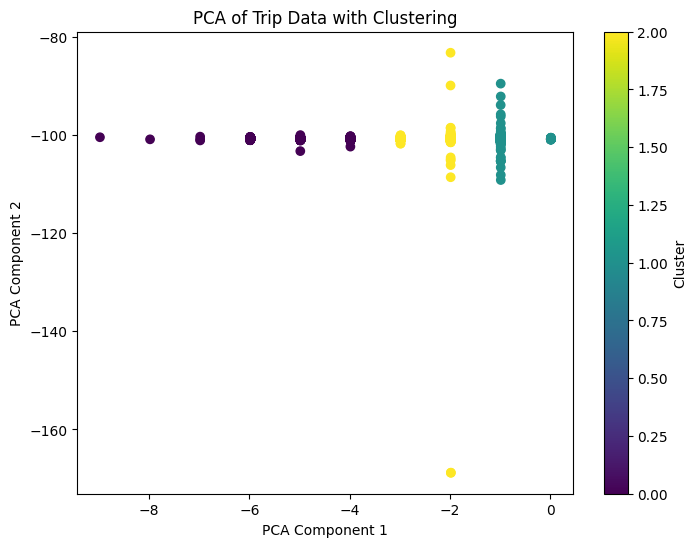

In [47]:
import matplotlib.pyplot as plt

# Extract PCA components and cluster predictions
pca_pd['pca1'] = pca_pd['pca_features'].apply(lambda x: x[0])  # First component
pca_pd['pca2'] = pca_pd['pca_features'].apply(lambda x: x[1])  # Second component

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pca_pd['pca1'], pca_pd['pca2'], c=pca_pd['prediction'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Trip Data with Clustering')
plt.colorbar(label='Cluster')
plt.show()

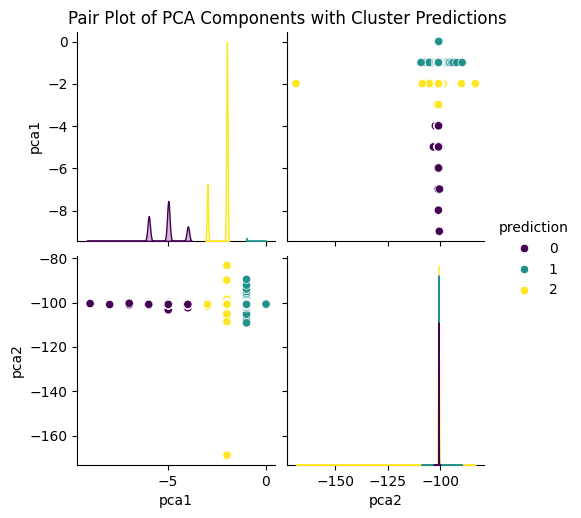

In [48]:
import seaborn as sns

# Pair plot to visualize the PCA components with cluster labels
sns.pairplot(pca_pd, hue='prediction', vars=['pca1', 'pca2'], palette='viridis')
plt.suptitle('Pair Plot of PCA Components with Cluster Predictions', y=1.02)
plt.show()

<ipython-input-49-c2d102805dfb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction', data=pca_pd, palette='viridis')


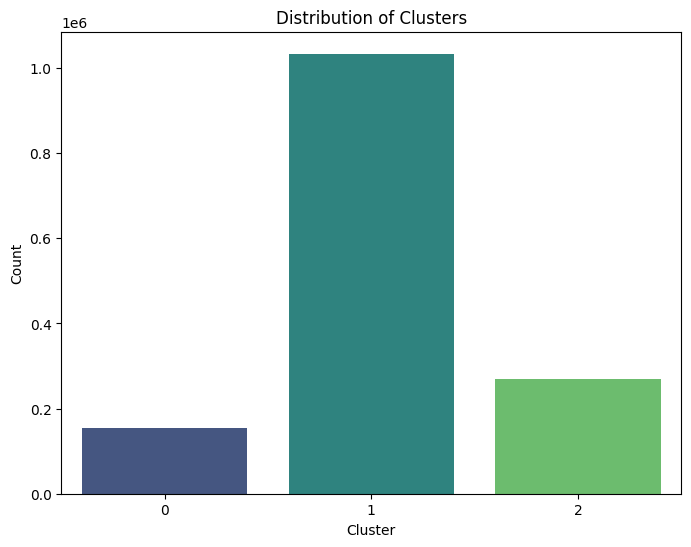

In [49]:
# Distribution of clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='prediction', data=pca_pd, palette='viridis')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

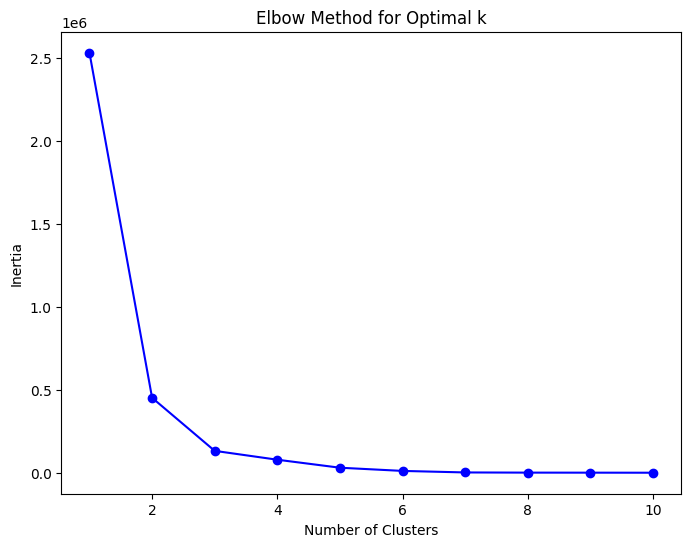

In [50]:
from sklearn.cluster import KMeans
import numpy as np

# Elbow plot to determine the optimal number of clusters
inertia = []
max_k = 10  # Adjust the maximum number of clusters to test
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_pd[['pca1', 'pca2']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k+1), inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

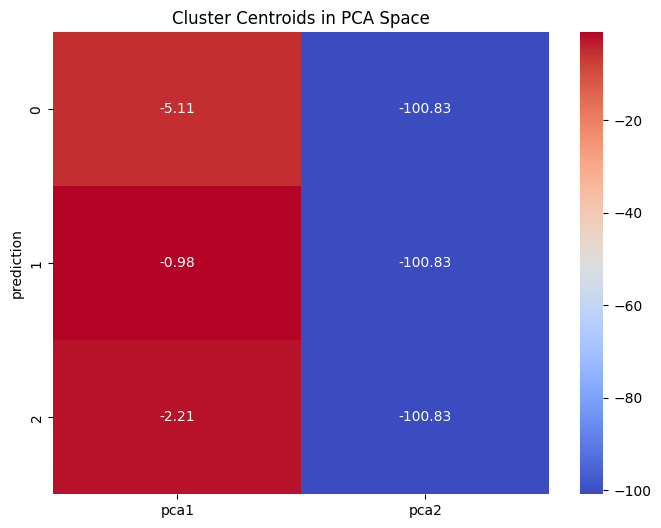

In [51]:
# Pivot the dataframe for heatmap
cluster_pca = pca_pd.groupby('prediction')[['pca1', 'pca2']].mean()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_pca, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Cluster Centroids in PCA Space')
plt.show()


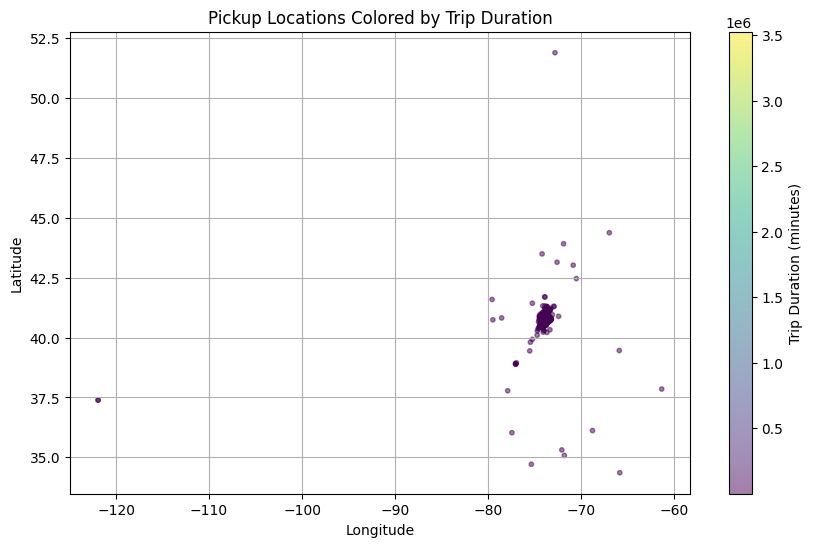

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (replace with your file path)
data = pd.read_csv("https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv")

# Sample data columns (you may need to adjust names)
# Assuming data has 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_duration'

# Scatter Plot: Pickup vs Dropoff with Trip Duration
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data['pickup_longitude'],
    data['pickup_latitude'],
    c=data['trip_duration'],
    cmap='viridis',
    alpha=0.5,
    s=10  # Marker size
)
plt.colorbar(scatter, label='Trip Duration (minutes)')
plt.title('Pickup Locations Colored by Trip Duration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

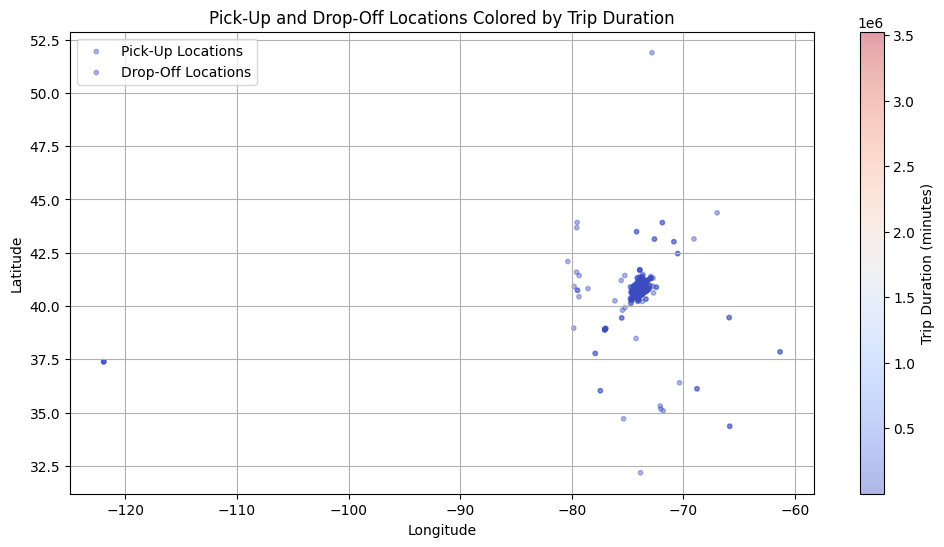

In [54]:
plt.figure(figsize=(12, 6))

# Scatter for Pick-Up Locations
plt.scatter(
    data['pickup_longitude'],
    data['pickup_latitude'],
    c=data['trip_duration'],
    cmap='coolwarm',
    alpha=0.4,
    s=10,
    label='Pick-Up Locations'
)

# Scatter for Drop-Off Locations
plt.scatter(
    data['dropoff_longitude'],
    data['dropoff_latitude'],
    c=data['trip_duration'],
    cmap='coolwarm',
    alpha=0.4,
    s=10,
    label='Drop-Off Locations'
)

plt.colorbar(label='Trip Duration (minutes)')
plt.title('Pick-Up and Drop-Off Locations Colored by Trip Duration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-80-6b1a7ba5be78>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data.groupby(['pickup_lat_bin', 'pickup_long_bin'])['trip_duration'].mean().unstack()


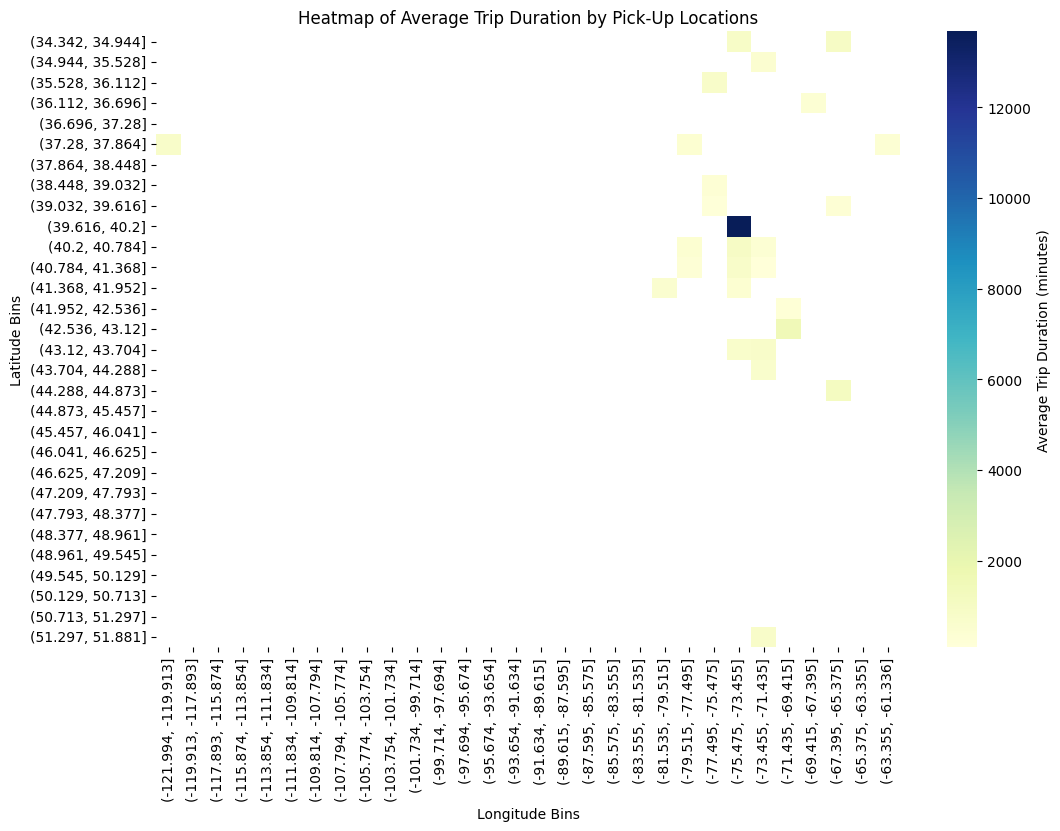

In [80]:
import seaborn as sns

# Create a new column for binned spatial data
data['pickup_long_bin'] = pd.cut(data['pickup_longitude'], bins=30)
data['pickup_lat_bin'] = pd.cut(data['pickup_latitude'], bins=30)

# Aggregate by bins
heatmap_data = data.groupby(['pickup_lat_bin', 'pickup_long_bin'])['trip_duration'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Average Trip Duration (minutes)'}
)
plt.title('Heatmap of Average Trip Duration by Pick-Up Locations')
plt.xlabel('Longitude Bins')
plt.ylabel('Latitude Bins')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable h

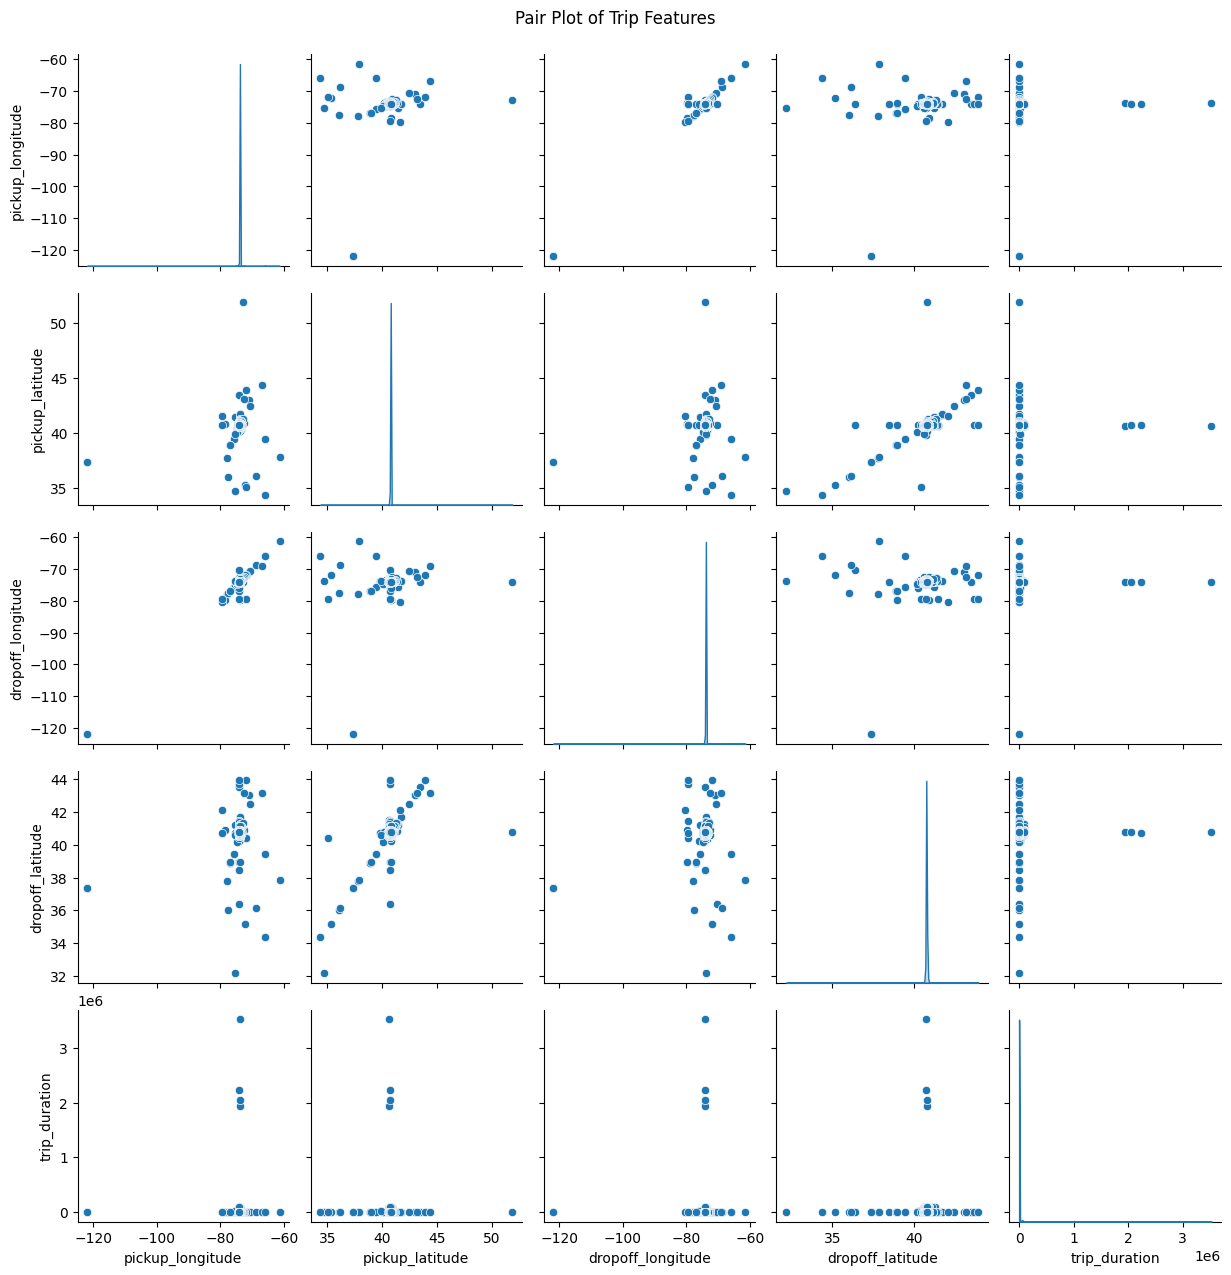

In [55]:
import seaborn as sns

# Select relevant columns
pairplot_data = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']]

# Pairplot with hue based on trip duration
sns.pairplot(pairplot_data, diag_kind='kde', palette='coolwarm')
plt.suptitle("Pair Plot of Trip Features", y=1.02)
plt.show()

<ipython-input-56-bd4661d62b22>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='trip_duration', data=data, palette='viridis')


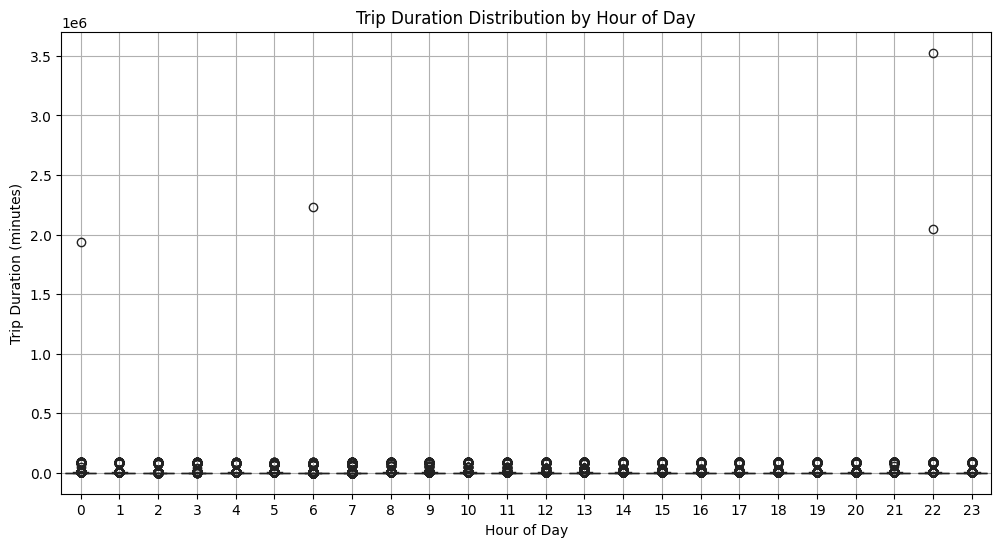

In [56]:
# Convert to datetime if necessary
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='trip_duration', data=data, palette='viridis')
plt.title('Trip Duration Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration (minutes)')
plt.grid(True)
plt.show()